In [44]:
import geopandas as gpd
import shapely
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import momepy
import os
import networkx as nx
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
cwd = os.getcwd()

In [3]:
# Change directory 
new_dir = cwd.replace('Code','Data/SPC_GIS/')
os.chdir(new_dir)

In [4]:
def read_file(filename):
    # Set filename
    filename = filename
    # Read file 
    data_out = gpd.read_file(filename)
    return data_out

In [5]:
nodes = read_file("new_node.shp")
edges = read_file("new_link.shp")

In [6]:
nodes.head(3)
len(nodes)
edges.head(3)
len(edges)

,ID,isOD,geometry
0,1,0,POINT (-79.83845 40.54487)
1,3,0,POINT (-80.03123 40.45891)
2,4,0,POINT (-79.06545 40.53644)


6014

,linkID,N1,N2,spd,lanes,l,isOD,note,X1,Y1,X2,Y2,geometry
0,8290,1,2114,25,1,0.04,0,8290,1388147.792,448212.542,1387767.306,449855.597,"LINESTRING (1388147.792 448212.542, 1388478.88..."
1,8291,1,5550,25,1,0.02,0,8291,1388147.792,448212.542,1388249.875,447637.094,"LINESTRING (1388147.792 448212.542, 1388135.13..."
2,1008267,1,1767,35,2,0.06,0,1008267+8266,1388147.792,448212.542,1387621.732,446190.858,"LINESTRING (1388147.792 448212.542, 1387932.01..."


16110

<AxesSubplot:>

<AxesSubplot:>

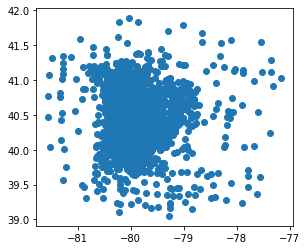

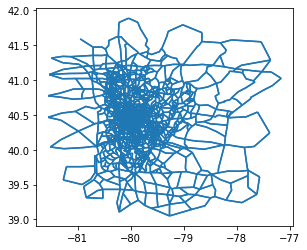

In [15]:
nodes.plot()
#nodes.crs
edges.plot()

In [16]:
new_dir = cwd.replace('Code', 'Data/PGH_neighborhoods/')
os.chdir(new_dir)

<AxesSubplot:>

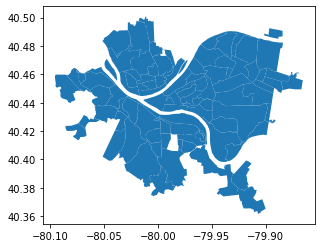

In [17]:
pgh_nhoods = read_file("Neighborhoods_.shp")   # https://data.wprdc.org/dataset/neighborhoods2
pgh_nhoods.plot()  # this is a polygon layer

In [18]:
# Select a subset of neighborhoods for which the analysis will be conducted
hood_list = pgh_nhoods['hood'].tolist()
hood_keep = ['Squirrel Hill North', 'Shadyside', 'East Liberty']  # smaller list for testing
# hood_keep = ["Central Oakland", 'North Oakland', 'South Oakland', 'Bloomfield', 'Garfield', 'Friendship', 'East Liberty', 
#              'Larimer', 'Shadyside', 'Squirrel Hill North', 'Squirrel Hill South', 'Greenfield', 'Hazelwood', 
#              'Glen Hazel']
pgh_nhoods_mask = pgh_nhoods[pgh_nhoods['hood'].isin(hood_keep)]  # subset the nhood polygon layer

77

<AxesSubplot:>

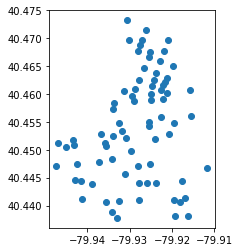

In [19]:
# clip the nodes: only include those within the selected neighborhoods
nodes_clip = gpd.clip(nodes, pgh_nhoods_mask)  
len(nodes_clip)
nodes_clip.plot()

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

275

<AxesSubplot:>

,linkID,N1,N2,spd,lanes,l,isOD,note,X1,Y1,X2,Y2,geometry
75,1003090,37,3461,25,2,0.05,0,1003090,1363567.250,414950.448,1361962.042,414213.990,"LINESTRING (-79.92393 40.45198, -79.92723 40.4..."
76,1003094,37,2894,20,1,0.02,0,1003094,1363567.250,414950.448,1363194.022,415773.493,"LINESTRING (-79.92393 40.45198, -79.92534 40.4..."
77,3097,37,727,25,2,0.02,0,3097,1363567.250,414950.448,1364456.833,415271.281,"LINESTRING (-79.92393 40.45198, -79.92196 40.4..."
117,1002803,59,1594,25,1,0.02,0,1002803,1362395.028,412111.181,1362391.556,410951.458,"LINESTRING (-79.92789 40.44410, -79.92780 40.4..."
118,1003119,59,187,25,1,0.02,0,1003119,1362395.028,412111.181,1361484.611,412697.323,"LINESTRING (-79.92789 40.44410, -79.93121 40.4..."


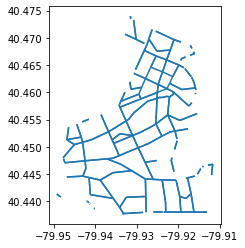

In [20]:
# The geometry of edges has a diferent coordinate ref system than the geometry of nodes and neighborhoods
# edges.crs
# pgh_nhoods_mask.crs
# nodes.crs

# Transform geometry of edges to the proper coord system
edges = edges.to_crs(epsg = 4326)
edges.crs

# Now edges can be clipped appropriately
edges_clip = gpd.clip(edges, pgh_nhoods_mask)
len(edges_clip)
edges_clip.plot()
edges_clip.head(5)

<AxesSubplot:>

<AxesSubplot:>

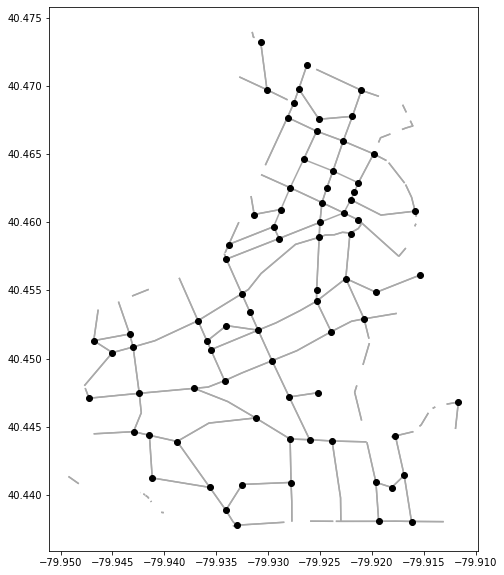

In [21]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_aspect('equal')
edges_clip.plot(ax=ax, color = 'darkgray', zorder=1)
nodes_clip.plot(ax=ax, color = 'black', zorder=2)
#pgh_nhoods_mask.plot(ax=ax, color = 'white', edgecolor='lightgrey', zorder=1)

,linkID,N1,N2,spd,lanes,l,isOD,note,X1,Y1,X2,Y2,geometry
75,1003090,37,3461,25,2,0.05,0,1003090,1363567.25,414950.448,1361962.042,414213.990,"LINESTRING (-79.92393 40.45198, -79.92723 40.4..."
76,1003094,37,2894,20,1,0.02,0,1003094,1363567.25,414950.448,1363194.022,415773.493,"LINESTRING (-79.92393 40.45198, -79.92534 40.4..."
77,3097,37,727,25,2,0.02,0,3097,1363567.25,414950.448,1364456.833,415271.281,"LINESTRING (-79.92393 40.45198, -79.92196 40.4..."


<AxesSubplot:>

<AxesSubplot:>

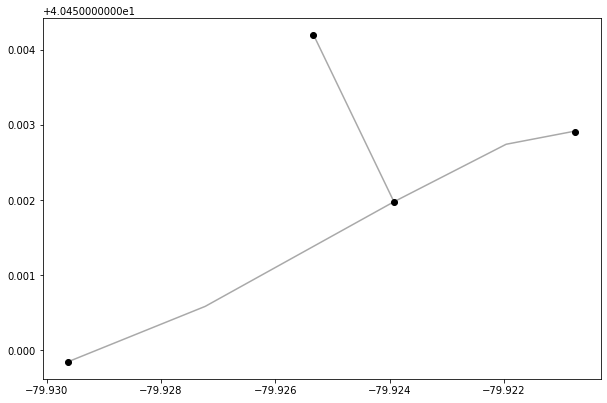

In [23]:
# Are 'N1' and 'N2' in edges df equivalent to 'ID' in nodes df? Test:
edges_clip = edges_clip.astype({'N1':'int32', 'N2':'int32'})
eclip_test = edges_clip[edges_clip['N1'] == 37]
eclip_test
nclip_test = nodes_clip[((nodes_clip['ID'] == 37) | (nodes_clip['ID'] == 3461) | (nodes_clip['ID'] == 2894) | (nodes_clip['ID'] == 727))]

fig, ax = plt.subplots(figsize=(10,10))
ax.set_aspect('equal')
eclip_test.plot(ax=ax, color = 'darkgray', zorder=1)
nclip_test.plot(ax=ax, color = 'black', zorder=2)
# this plot shows that N1 and N2 columns in edges df are equivalent to ID column in nodes df

In [84]:
def plot_nodes_and_edges(nodes_df, edges_df):
    fig, ax = plt.subplots(figsize=(10,10))
    ax.set_aspect('equal')
    edges_df.plot(ax=ax, color = 'darkgray', zorder=1)
    nodes_df.plot(ax=ax, color = 'black', zorder=2)
    return ax

In [39]:
nodes_clip.loc[27]['geometry'].x
nodes_clip.loc[27]['geometry'].y

-79.923923

In [26]:
def linestring_to_points(line):
    return (line.coords)

#edges_clip['points'] = edges_clip.apply(lambda l: linestring_to_points(l['geometry']),axis=1)

In [82]:
def nx_pos(x, y):
    return {'pos': (x,y)}

In [83]:
nodes_clip.columns

Index(['ID', 'isOD', 'geometry', 'x', 'y', 'nx_node_form'], dtype='object')

In [93]:
# add x-y columns for coordinates 
nodes_clip['x'] = nodes_clip.apply(lambda p: p['geometry'].x, axis=1)
nodes_clip['y'] = nodes_clip.apply(lambda p: p['geometry'].y, axis=1)
nodes_clip['nx_pos'] = nodes_clip.apply(lambda p: nx_pos(p['x'], p['y']), axis=1)

In [95]:
# add nodes to the graph, including their positions 
graph_nodes = list(zip(nodes_clip.ID.tolist(),nodes_clip.nx_pos.tolist()))
G = nx.DiGraph()
G.add_nodes_from(graph_nodes)
G.nodes[37]['pos']
1007 in list(G.nodes)

(-79.923923, 40.451967)

False

In [100]:
nodelist = list(G.nodes)
1007 in nodelist
list(zip(*graph_edges))

False

[(37,
  37,
  37,
  59,
  59,
  59,
  187,
  187,
  187,
  430,
  430,
  430,
  430,
  430,
  451,
  451,
  541,
  541,
  541,
  541,
  715,
  727,
  727,
  727,
  727,
  747,
  747,
  747,
  1004,
  1004,
  1007,
  1080,
  1080,
  1080,
  1227,
  1227,
  1227,
  1320,
  1322,
  1322,
  1322,
  1322,
  1503,
  1594,
  1594,
  1594,
  1614,
  1614,
  1614,
  1652,
  1652,
  1652,
  1652,
  1675,
  1675,
  1675,
  1675,
  1721,
  1721,
  1721,
  1891,
  1912,
  1912,
  1922,
  1922,
  1922,
  1961,
  2026,
  2113,
  2121,
  2121,
  2121,
  2159,
  2251,
  2251,
  2251,
  2279,
  2279,
  2314,
  2314,
  2387,
  2387,
  2387,
  2409,
  2409,
  2409,
  2409,
  2615,
  2615,
  2615,
  2680,
  2680,
  2695,
  2695,
  2695,
  2727,
  2727,
  2727,
  2731,
  2731,
  2731,
  2731,
  2837,
  2894,
  2894,
  2894,
  2894,
  2990,
  2990,
  2990,
  2990,
  3177,
  3177,
  3244,
  3244,
  3244,
  3403,
  3403,
  3403,
  3403,
  3437,
  3437,
  3437,
  3439,
  3439,
  3439,
  3461,
  3461,
  3461,
  

In [104]:
edges_clip['edge'] = edges_clip.apply(lambda l: (l['N1'], l['N2']), axis=1)
edges_clip_subset = edges_clip[(edges_clip['N1'].isin(G.nodes)) & (edges_clip['N2'].isin(G.nodes))]
graph_edges = edges_clip_subset['edge'].tolist()
#graph_edges
G.add_edges_from(graph_edges)

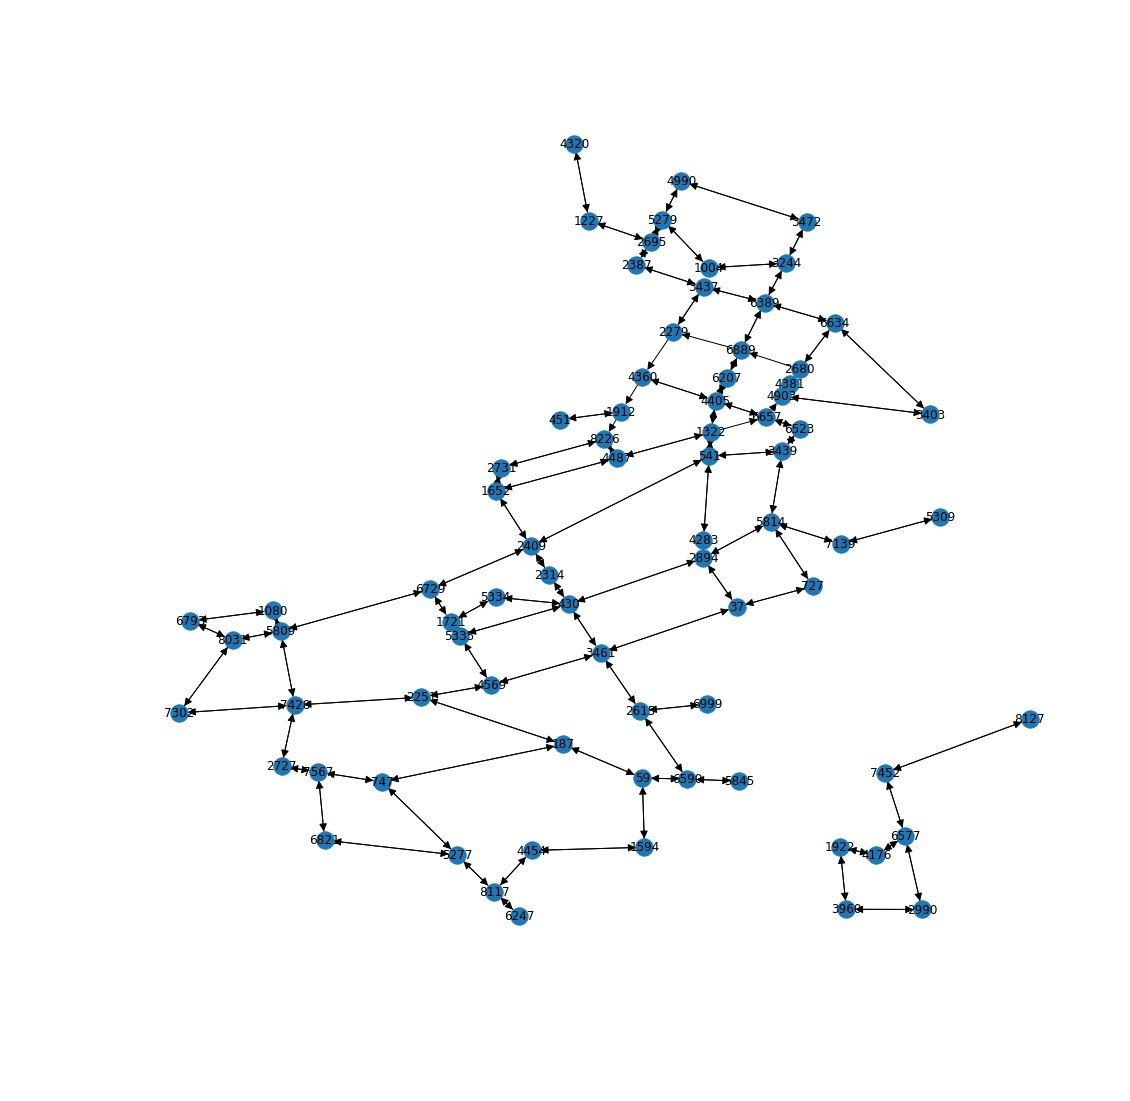

In [106]:
node_coords = nx.get_node_attributes(G, 'pos')
fig, ax = plt.subplots(figsize=(20,20))
nx.draw(G, pos=node_coords, with_labels=True, arrowsize=16, ax=ax)

In [ ]:
# draw the graph, which includes nodes located by their coordinates, and edges
# if show_zones == Y, then also draw the walking catchment zone around each fixed node
def draw_graph(G, all_node_color_map, node_color_legend, node_size, font_size, font_color, 
               edge_color, edge_width):
    fig, ax = plt.subplots(figsize=(12,10))
    node_coords = nx.get_node_attributes(G, 'pos')
    
    node_color = [all_node_color_map[re.sub(r'[^a-zA-Z]', '', node)] for node in G]
    
    nx.draw(G, pos=node_coords, with_labels = True, node_color = node_color, font_color = font_color, 
            font_size = font_size, font_weight = 'bold', node_size = node_size, arrowsize = 16, edge_color = edge_color, 
            width = edge_width, alpha = 0.8, ax=ax)
    ax.set_axis_on() # turns on axis
    ax.margins(0.1,0.1)
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    
    # add legend for node color
    inv_node_cmap = {val:key for key,val in node_color_legend.items()}  # dict of form {color: long_mode_name}
    for v in set(inv_node_cmap.keys()):
        if inv_node_cmap[v] in ['org','dst']:
            ax.scatter([],[], c=v, label='org/dst')
        else:
            ax.scatter([],[], c=v, label=inv_node_cmap[v])
    ax.legend(loc = 'lower right')
        
#     ax.set_xlim([axlims[0],axlims[1]])
#     ax.set_ylim([axlims[2],axlims[3]])
    return ax

267

<AxesSubplot:>

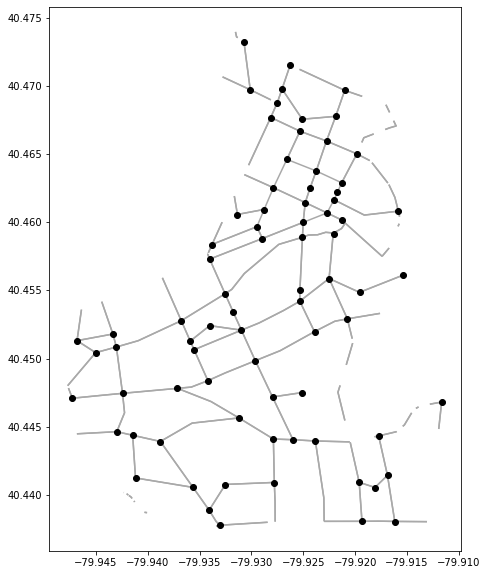

In [87]:
# Note that in the figure of nodes_clip and edges_clip, there are some detached roads. Let's only include a fully connected network
nodes_included = nodes_clip['ID'].tolist()
node_mask = edges_clip['N1'].isin(nodes_included) | edges_clip['N2'].isin(nodes_included)
new_edges_clip = edges_clip[node_mask]
len(new_edges_clip)
plot_nodes_and_edges(nodes_clip, new_edges_clip)

In [98]:
# momepy citation: Fleischmann, M. (2019) ‘momepy: Urban Morphology Measuring Toolkit’, Journal of Open Source Software, 4(43), p. 1807. doi: 10.21105/joss.01807.
#graph = momepy.gdf_to_nx(edges_clip, approach='primal')
edges_clip['geometry'].tolist()

In [ ]:
# Healthy Ride depots:  https://data.wprdc.org/dataset/healthyride-stations